In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

In [2]:
# Get the USPS dataset
batch_size = 128

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.EuroSAT(root='./data', download=False, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

classes = ('AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake')

NameError: name 'transforms' is not defined

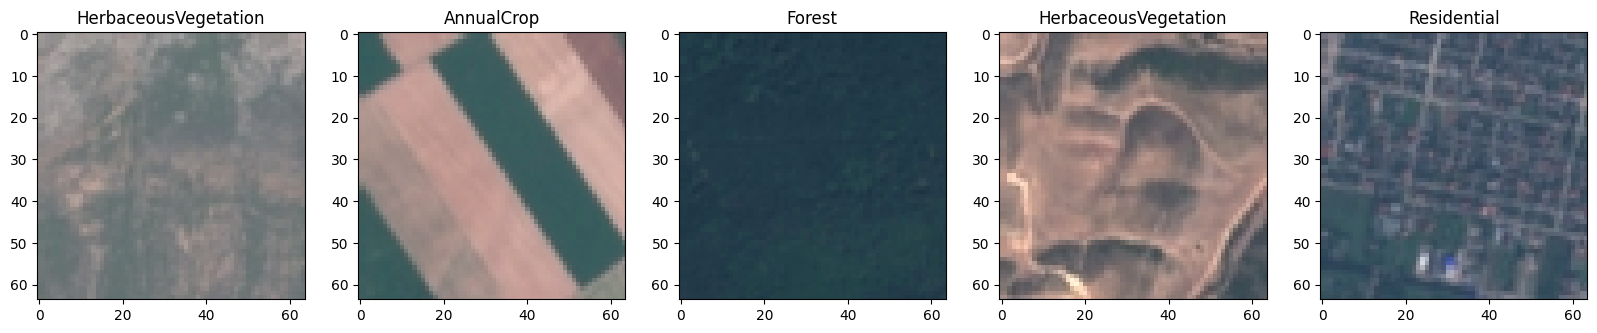

In [3]:
def show_image(dataset, index):
    image, label = dataset[index]
    image = image / 2 + 0.5
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    plt.title(classes[label])

plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    show_image(train_dataset, i * 100)
plt.show()

In [4]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.flattend_size = 32 * 4 * 4
        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(16, 32, 7, padding=3)
        self.fc1 = nn.Linear(self.flattend_size, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)
        self.batch_norm = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batch_norm(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batch_norm2(x)
        x = x.view(-1, self.flattend_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
def train(net, trainloader, optimizer, loss):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss_val = loss(outputs, labels)
        loss_val.backward()
        optimizer.step()
        running_loss += loss_val.item()

        if i % 5 == 0:
            print(f"[{i + 1}, {len(trainloader)}] loss: {running_loss / 100}")
            running_loss = 0.0

    return running_loss / len(trainloader)

def test(net, testloader, loss):
    net.eval()
    running_loss = 0.0
    correct      = 0
    total        = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss_val = loss(outputs, labels)
            running_loss += loss_val.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def training_loop(epochs, net, trainloader, testloader, optimizer, loss):
    accuracies = []
    losses = []


    start_time = time.time()
    for epoch in range(epochs):
        train_loss = train(net, trainloader, optimizer, loss)
        accuracy = test(net, testloader, loss)
        accuracies.append(accuracy)
        losses.append(train_loss)
        print(f"Epoch {epoch} - Train Loss: {train_loss} Accuracy: {accuracy}")

    end_time = time.time()

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(accuracies)
    plt.title('Accuracy')
    plt.xlabel('Epoch [#]')
    plt.ylabel('Accuracy [%]')
    plt.subplot(122)
    plt.plot(losses)
    plt.title('Loss')
    plt.xlabel('Epoch [#]')
    plt.ylabel('Loss [NLL]')
    plt.show()

    return accuracies, losses, end_time - start_time

In [7]:
net = CustomCNN()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
loss = nn.CrossEntropyLoss()
net.to(device)

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

/home/alex/Documents/Studium/Master-2/ki-lab-ss23/.venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


[1, 169] loss: 0.023041629791259767
[6, 169] loss: 0.11361366748809815
[11, 169] loss: 0.11195270538330078
[16, 169] loss: 0.10996250629425049
[21, 169] loss: 0.10825084209442139
[26, 169] loss: 0.10698937177658081
[31, 169] loss: 0.10494321346282959
[36, 169] loss: 0.10289296150207519
[41, 169] loss: 0.10138325810432434
[46, 169] loss: 0.09945446610450745
[51, 169] loss: 0.09767846584320068
[56, 169] loss: 0.09549438714981079
[61, 169] loss: 0.09388878464698791
[66, 169] loss: 0.0906765878200531
[71, 169] loss: 0.08906224727630616
[76, 169] loss: 0.08679080247879029
[81, 169] loss: 0.0863106918334961
[86, 169] loss: 0.08411754369735717
[91, 169] loss: 0.08366849660873413
[96, 169] loss: 0.08234914422035217
[101, 169] loss: 0.08281700849533082
[106, 169] loss: 0.07797511458396912
[111, 169] loss: 0.07649551868438721
[116, 169] loss: 0.0761444890499115
[121, 169] loss: 0.07533391952514648
[126, 169] loss: 0.0713454806804657
[131, 169] loss: 0.07341741442680359
[136, 169] loss: 0.0712417

[41, 169] loss: 0.05978644847869873
[46, 169] loss: 0.06059507846832275
[51, 169] loss: 0.05857846736907959
[56, 169] loss: 0.05755216121673584
[61, 169] loss: 0.05734791398048401
[66, 169] loss: 0.05280949592590332
[71, 169] loss: 0.05562530517578125
[76, 169] loss: 0.05464038133621216
[81, 169] loss: 0.05349362850189209
[86, 169] loss: 0.05217292010784149
[91, 169] loss: 0.05325016021728515
[96, 169] loss: 0.05265221893787384
[101, 169] loss: 0.04967839479446411
[106, 169] loss: 0.054147220253944396
[111, 169] loss: 0.053706475496292115
[116, 169] loss: 0.04604728102684021
[121, 169] loss: 0.04809677064418793
[126, 169] loss: 0.04698947846889496
[131, 169] loss: 0.051247671842575074
[136, 169] loss: 0.04634344518184662
[141, 169] loss: 0.04787390112876892
[146, 169] loss: 0.04568837642669678
[151, 169] loss: 0.04706739127635956
[156, 169] loss: 0.04736444354057312
[161, 169] loss: 0.04622620105743408
[166, 169] loss: 0.04595627009868622
Epoch 1 - Train Loss: 0.016570973325763228 Accu

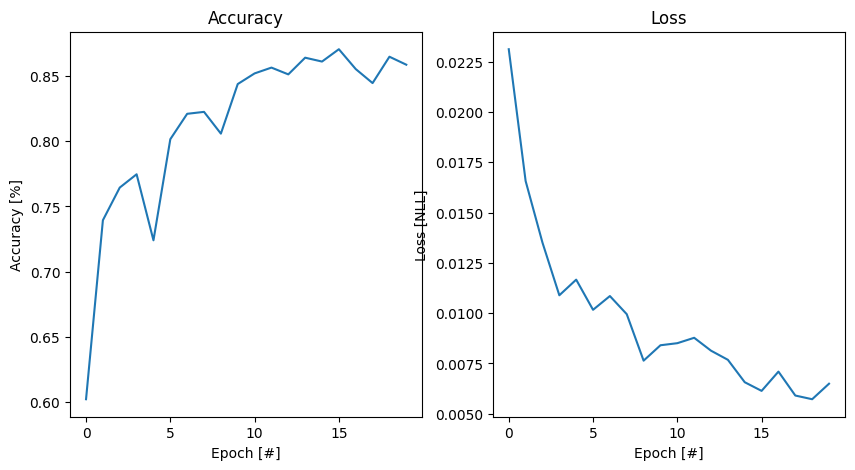

Best accuracy: 0.8703703703703703


In [8]:
EPOCHS = 20

accuracies_custom, losses_custom, time_custom = training_loop(EPOCHS, net, trainloader, testloader, optimizer, loss)

print(f"Best accuracy: {max(accuracies_custom)}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/alex/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


Training last resnet layer
[1, 169] loss: 0.02654287815093994
[6, 169] loss: 0.11892755270004272
[11, 169] loss: 0.09987950682640076
[16, 169] loss: 0.08849681496620178
[21, 169] loss: 0.07713830471038818
[26, 169] loss: 0.06943400502204895
[31, 169] loss: 0.06347841501235962
[36, 169] loss: 0.059904849529266356
[41, 169] loss: 0.055638991594314575
[46, 169] loss: 0.047230573892593386
[51, 169] loss: 0.047269591689109804
[56, 169] loss: 0.049953493475914004
[61, 169] loss: 0.041505449414253236
[66, 169] loss: 0.041993553638458254
[71, 169] loss: 0.03892683207988739
[76, 169] loss: 0.039985020756721494
[81, 169] loss: 0.03730420589447021
[86, 169] loss: 0.03851270496845245
[91, 169] loss: 0.037281135320663454
[96, 169] loss: 0.037614189982414246
[101, 169] loss: 0.036005645990371704
[106, 169] loss: 0.03225227057933808
[111, 169] loss: 0.032471309900283817
[116, 169] loss: 0.03699797093868255
[121, 169] loss: 0.033599735498428346
[126, 169] loss: 0.03476069629192352
[131, 169] loss: 0.0

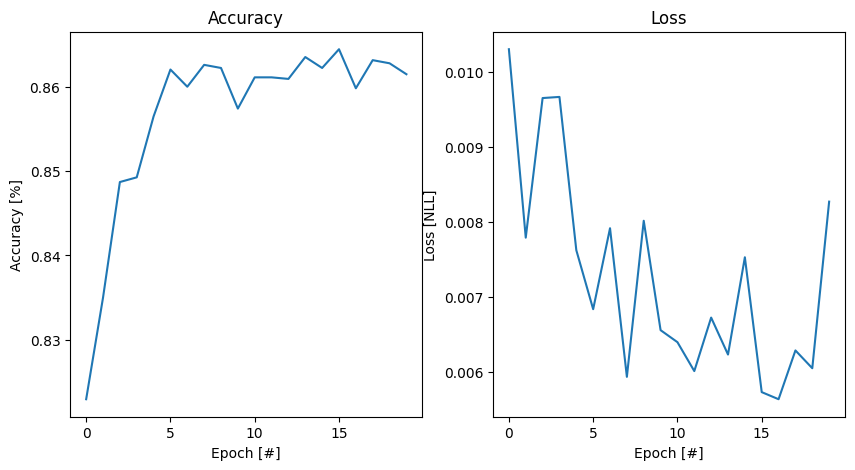

Best accuracy: 0.8644444444444445


In [9]:
resnet_fc = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Freeze all layers except the last one
for name, param in resnet_fc.named_parameters():
    param.requires_grad = False

resnet_fc.fc = nn.Linear(512, 10)

resnet_fc.to(device)

# Train the last layer
optimizer = optim.Adam(resnet_fc.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()
resnet_fc.to(device)

print("Training last resnet layer")

accuracies_resnet_fc, losses_resnet_fc, time_resnet_fc = training_loop(EPOCHS, resnet_fc, trainloader, testloader, optimizer, loss)

print(f"Best accuracy: {max(accuracies_resnet_fc)}")

Fine tuning resnet
[1, 169] loss: 0.02668445587158203
[6, 169] loss: 0.09260764837265015
[11, 169] loss: 0.05657726049423218
[16, 169] loss: 0.04007695376873016
[21, 169] loss: 0.031133989691734313
[26, 169] loss: 0.021556410789489746
[31, 169] loss: 0.017004529535770415
[36, 169] loss: 0.01639343947172165
[41, 169] loss: 0.015455044358968734
[46, 169] loss: 0.012683854848146438
[51, 169] loss: 0.01414403811097145
[56, 169] loss: 0.011733898371458053
[61, 169] loss: 0.011525448113679886
[66, 169] loss: 0.011019265800714493
[71, 169] loss: 0.012124048322439194
[76, 169] loss: 0.009371282756328583
[81, 169] loss: 0.009316332340240478
[86, 169] loss: 0.011025694906711578
[91, 169] loss: 0.010032650902867318
[96, 169] loss: 0.007498557418584823
[101, 169] loss: 0.007862459197640418
[106, 169] loss: 0.009761412292718888
[111, 169] loss: 0.006908233463764191
[116, 169] loss: 0.007596253380179405
[121, 169] loss: 0.008730876818299293
[126, 169] loss: 0.007029698118567467
[131, 169] loss: 0.00

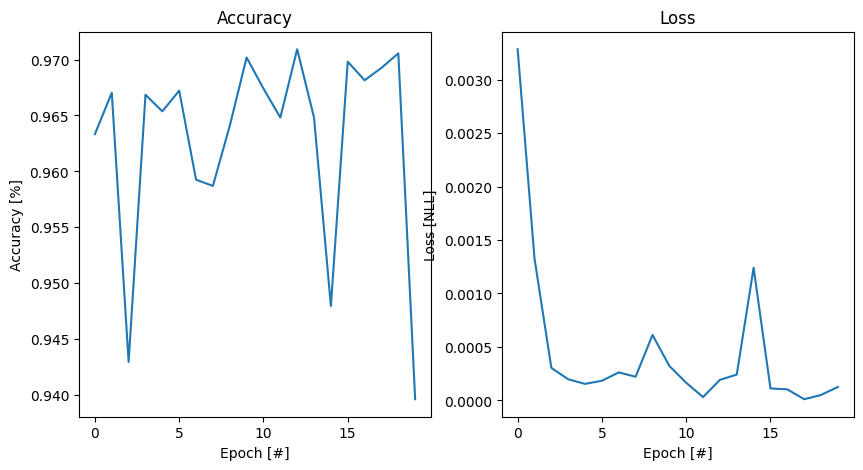

Best accuracy: 0.970925925925926


In [10]:
resnet_finetuned    = torchvision.models.resnet18(weights='IMAGENET1K_V1')
resnet_finetuned.fc = nn.Linear(512, 10)

resnet_finetuned.to(device)

# Train the last layer
optimizer = optim.Adam(resnet_finetuned.parameters(), lr=1e-4)
loss = nn.CrossEntropyLoss()
resnet_finetuned.to(device)

print("Fine tuning resnet")
accuracies_resnet_ft, losses_resnet_ft, time_resnet_ft = training_loop(EPOCHS, resnet_finetuned, trainloader, testloader, optimizer, loss)

print(f"Best accuracy: {max(accuracies_resnet_ft)}")

Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /home/alex/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100.0%


Training last effnet layer
[1, 169] loss: 0.022963786125183107
[6, 169] loss: 0.10902056217193604
[11, 169] loss: 0.09977472901344299
[16, 169] loss: 0.09360353946685791
[21, 169] loss: 0.08685218453407288
[26, 169] loss: 0.08020987510681152
[31, 169] loss: 0.07867244958877563
[36, 169] loss: 0.07575571656227112
[41, 169] loss: 0.07626815915107726
[46, 169] loss: 0.07249337315559387
[51, 169] loss: 0.07119096040725709
[56, 169] loss: 0.07068113803863525
[61, 169] loss: 0.06876870274543762
[66, 169] loss: 0.07245599031448365
[71, 169] loss: 0.06805093884468079
[76, 169] loss: 0.06476690292358399
[81, 169] loss: 0.06661329030990601
[86, 169] loss: 0.0659792184829712
[91, 169] loss: 0.06457889318466187
[96, 169] loss: 0.06594775438308716
[101, 169] loss: 0.06171969056129455
[106, 169] loss: 0.06148625373840332
[111, 169] loss: 0.06316893458366395
[116, 169] loss: 0.06301812052726746
[121, 169] loss: 0.06409798383712768
[126, 169] loss: 0.06198342800140381
[131, 169] loss: 0.05902489542961

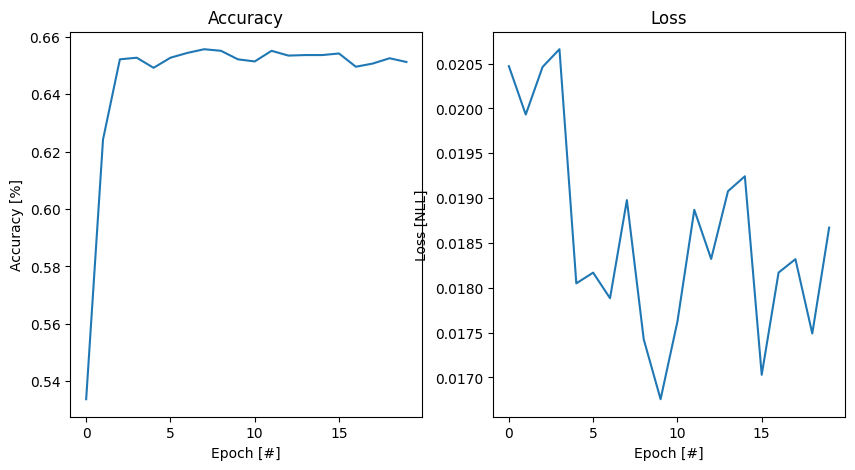

Best accuracy: 0.6557407407407407


In [11]:
effnet_fc = torchvision.models.efficientnet_b5(weights='IMAGENET1K_V1')

for name, param in effnet_fc.named_parameters():
    param.requires_grad = False

effnet_fc.classifier = nn.Linear(2048, 10)

effnet_fc.to(device)

# Train the last layer
optimizer = optim.Adam(effnet_fc.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()
effnet_fc.to(device)

print("Training last effnet layer")

accuracies_effnet_fc, losses_effnet_fc, time_effnet_fc = training_loop(EPOCHS, effnet_fc, trainloader, testloader, optimizer, loss)
print(f"Best accuracy: {max(accuracies_effnet_fc)}")

Fine tune effnet
[1, 169] loss: 0.023136711120605467
[6, 169] loss: 0.1132509708404541
[11, 169] loss: 0.10770771265029908
[16, 169] loss: 0.10258086681365967
[21, 169] loss: 0.09631919145584106
[26, 169] loss: 0.0880938446521759
[31, 169] loss: 0.08643815159797669
[36, 169] loss: 0.07729236483573913
[41, 169] loss: 0.07175901770591736
[46, 169] loss: 0.06842302560806274
[51, 169] loss: 0.0638633418083191
[56, 169] loss: 0.06024844288825989
[61, 169] loss: 0.05842015743255615
[66, 169] loss: 0.050214191675186155
[71, 169] loss: 0.047803805470466615
[76, 169] loss: 0.04368349373340607
[81, 169] loss: 0.03925680875778198
[86, 169] loss: 0.03947933077812195
[91, 169] loss: 0.036562896966934204
[96, 169] loss: 0.0351029771566391
[101, 169] loss: 0.02906093865633011
[106, 169] loss: 0.030003259181976317
[111, 169] loss: 0.027851299047470093
[116, 169] loss: 0.030377505421638487
[121, 169] loss: 0.026675826907157897
[126, 169] loss: 0.02617197245359421
[131, 169] loss: 0.021466069221496582
[

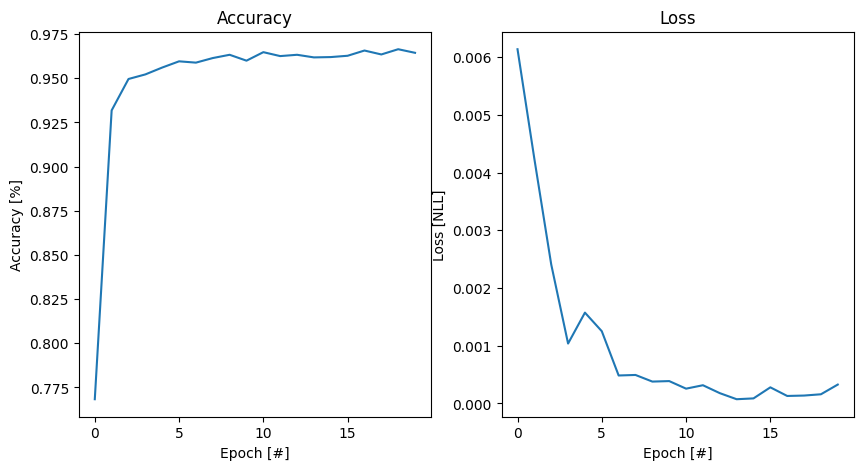

Best accuracy: 0.9664814814814815


In [12]:
effnet_ft = torchvision.models.efficientnet_b5(weights='IMAGENET1K_V1')
effnet_ft.classifier = nn.Linear(2048, 10)

effnet_ft.to(device)

optimizer = optim.Adam(effnet_ft.parameters(), lr=1e-4)
loss = nn.CrossEntropyLoss()
effnet_ft.to(device)

print("Fine tune effnet")

accuracies_effnet_ft, losses_effnet_ft, time_effnet_ft = training_loop(EPOCHS, effnet_ft, trainloader, testloader, optimizer, loss)
print(f"Best accuracy: {max(accuracies_effnet_ft)}")


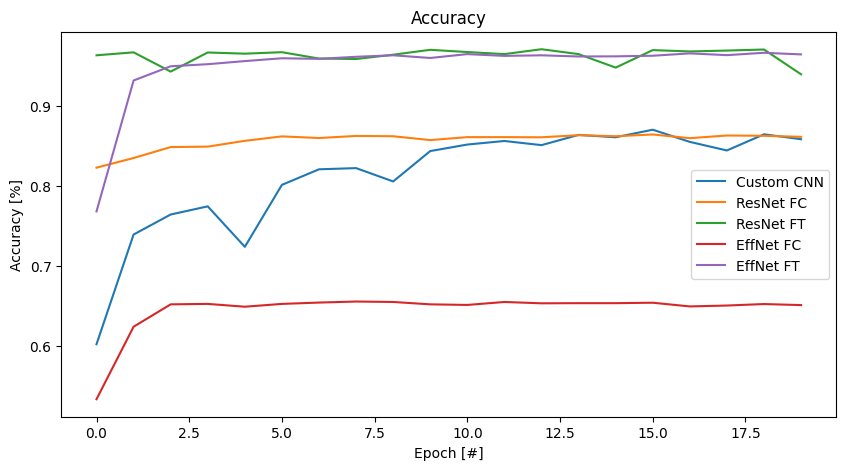

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(accuracies_custom, label='Custom CNN')
plt.plot(accuracies_resnet_fc, label='ResNet FC')
plt.plot(accuracies_resnet_ft, label='ResNet FT')
plt.plot(accuracies_effnet_fc, label='EffNet FC')
plt.plot(accuracies_effnet_ft, label='EffNet FT')
plt.title('Accuracy')
plt.xlabel('Epoch [#]')
plt.ylabel('Accuracy [%]')
plt.legend()
plt.show()

In [14]:
def f_time(time):
    return f"{time // 60}m {round(time % 60)}s"

print(f"Custom CNN: {f_time(time_custom)}")
print(f"ResNet FC: {f_time(time_resnet_fc)}")
print(f"ResNet FT: {f_time(time_resnet_ft)}")
print(f"EffNet FC: {f_time(time_effnet_fc)}")
print(f"EffNet FT: {f_time(time_effnet_ft)}")

Custom CNN: 1.0m 18s
ResNet FC: 1.0m 20s
ResNet FT: 2.0m 25s
EffNet FC: 6.0m 8s
EffNet FT: 19.0m 55s


# AMD RX 5700 XT
Custom CNN: 2.0m 3s

ResNet FC: 2.0m 30s

ResNet FT: 4.0m 6s

EffNet FC: 9.0m 30s

EffNet FT: 26.0m 58s

# nVidia RTX 3060
Custom CNN: 1.0m 18s

ResNet FC: 1.0m 20s

ResNet FT: 2.0m 25s

EffNet FC: 6.0m 8s

EffNet FT: 19.0m 55s